In [5]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [6]:
# Load and preprocess data
def preprocess_data(filepath):
    # Read raw data
    daily_data = pd.read_csv(filepath)
    
    # Rename columns
    df = daily_data.rename(index=str, columns={
        "Sl no.": "Sl_no", 
        "Min Price (Rs./Quintal)": "Min_Price",
        "Price Date": "Price_Date",
        "Modal Price (Rs./Quintal)": "Modal_Price"
    })
    
    # Convert dates and sort
    df.Price_Date = pd.to_datetime(df.Price_Date, errors='coerce')
    df = df.sort_values(by='Price_Date')
    df.drop_duplicates('Price_Date', inplace=True)
    
    return df[['Modal_Price', 'Price_Date']]


In [7]:
def fit_predict_sarima(data):
    # Prepare time series
    data.Price_Date = pd.to_datetime(data.Price_Date)
    data = data.set_index('Price_Date')
    y = data['Modal_Price'].resample('MS').mean()
    y = y.fillna(y.bfill())
    
    # SARIMA parameters
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    
    # Find best model
    best_aic = float("inf")
    best_params = None
    best_seasonal_params = None
    
    warnings.filterwarnings("ignore")
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                              order=param,
                                              seasonal_order=param_seasonal,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
                results = mod.fit()
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_params = param
                    best_seasonal_params = param_seasonal
            except:
                continue
    
    # Fit final model
    final_model = sm.tsa.statespace.SARIMAX(y,
                                         order=best_params,
                                         seasonal_order=best_seasonal_params,
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)
    final_results = final_model.fit()
    
    # Generate predictions
    pred_uc = final_results.get_forecast(steps=20)
    pred_ci = pred_uc.conf_int()
    
    # Plot results
    plt.figure(figsize=(20,15))
    ax = y.plot(label='Observed')
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.legend()
    plt.title('Rice Price Forecast')
    plt.show()
    
    return pred_ci

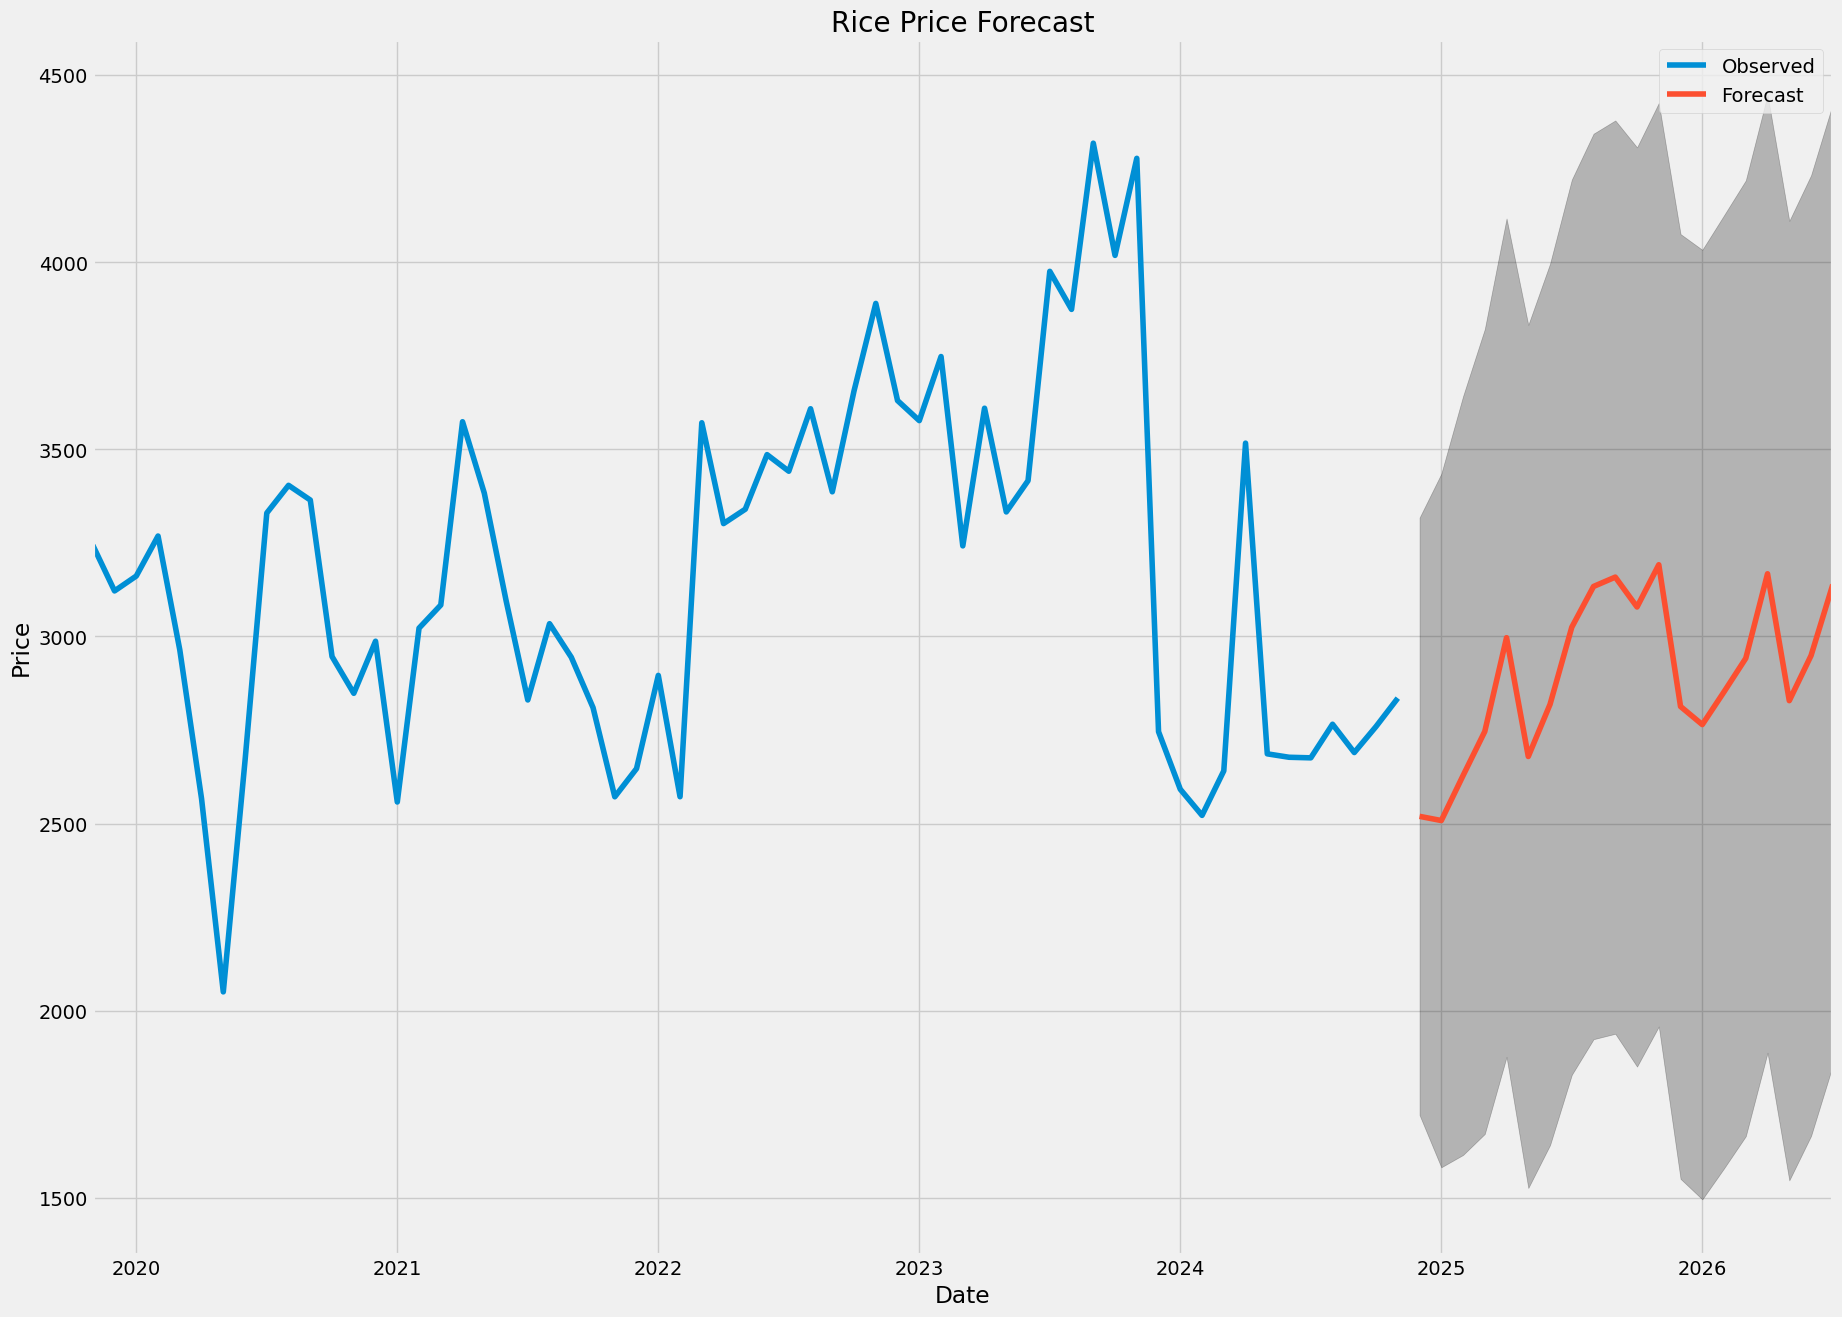


Predicted price ranges:
            lower Modal_Price  upper Modal_Price
2024-12-01        1721.105227        3317.582272
2025-01-01        1581.380445        3434.876599
2025-02-01        1614.367394        3642.018042
2025-03-01        1670.648555        3821.648839
2025-04-01        1876.530531        4117.047914
2025-05-01        1526.072540        3832.533404
2025-06-01        1640.810897        3996.329735
2025-07-01        1828.610366        4220.872560
2025-08-01        1923.727458        4343.641089
2025-09-01        1938.278324        4379.072232
2025-10-01        1850.542463        4307.138448
2025-11-01        1957.669314        4425.703921
2025-12-01        1550.525373        4075.374659
2026-01-01        1495.757087        4033.351662
2026-02-01        1578.561657        4125.731233
2026-03-01        1664.533955        4218.950769
2026-04-01        1887.653644        4447.574676
2026-05-01        1546.441511        4110.549960
2026-06-01        1665.221801        4232.51

In [8]:
raw_data = preprocess_data("./Dataset/Raw_Wheat.csv")
predictions = fit_predict_sarima(raw_data)
print("\nPredicted price ranges:")
print(predictions)